In [358]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz
import numpy as np

conda install -c anaconda python-graphviz

conda install -c anaconda pydot

In [359]:
giocatori = pd.read_csv('dataset\giocatori.csv')

giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)
giocatori = giocatori.drop('RIM_D', axis = 1)
giocatori = giocatori.drop('RIM_O', axis = 1)
giocatori = giocatori.drop('T1_PER', axis = 1)
giocatori = giocatori.drop('T2_PER', axis = 1)
giocatori = giocatori.drop('T3_PER', axis = 1)

players_without_role = giocatori.loc[(giocatori["ruolo"].isnull()) | (giocatori["ruolo"] == "NaN")]
players_without_role = players_without_role.drop('ruolo', axis = 1)

giocatori = giocatori.dropna();

# Definire una funzione per scalare i valori di ogni riga
def scale_cols(df, col):
    df = df[df[col] != 0]
    factor = 40/df[col].values
    float_cols = df.select_dtypes(include=['float64']).columns
    float_cols = float_cols.drop(col)
    df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
    return df

players_without_role = scale_cols(players_without_role, 'minuti')
players_without_role = players_without_role.drop('minuti', axis = 1)
players_without_role["altezza"] = players_without_role["altezza"].replace(0, np.nan, inplace=True)

giocatori = scale_cols(giocatori, 'minuti')
giocatori = giocatori.drop('minuti', axis = 1)

C:\Users\nicol\AppData\Local\Temp\ipykernel_16096\1143009646.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
C:\Users\nicol\AppData\Local\Temp\ipykernel_16096\1143009646.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)


In [360]:
x = giocatori.drop('ruolo', axis=1)
y = giocatori['ruolo']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=100)

In [361]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 9,11,None],
              'min_samples_split': [2, 10, 30, 50]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(x, y)
clf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best score: %0.2f" % grid_search.best_score_)

Best parameters found:  {'max_depth': 3, 'min_samples_split': 2}
Best score: 0.69


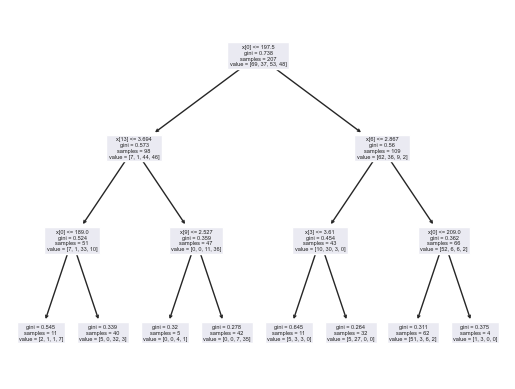

In [362]:
tree.plot_tree(clf)
plt.show()

In [363]:
#Esportazione albero di decisione
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("ruoli_tree")

'ruoli_tree.pdf'

In [364]:
#Quasto modello non può lavorare con valori nulli. Dunque si scarta in caso si abbiano giocatori con valori nulli.
#y_pred = grid_search.predict(players_without_role)
#print(players_without_role.values)
#print(y_pred)

In [365]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import datasets

HGBC = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1)
HGBC.fit(x, y)

scores = cross_val_score(HGBC, x, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.65 (+/- 0.06)


In [366]:
y_pred = HGBC.predict(players_without_role)
print(y_pred)


['Guardia' 'Guardia' 'Guardia' 'Guardia' 'Guardia' 'Ala' 'Guardia'
 'Guardia' 'Guardia' 'Guardia' 'Play' 'Ala' 'Guardia' 'Guardia' 'Guardia'
 'Ala' 'Play' 'Centro' 'Guardia' 'Guardia' 'Guardia' 'Guardia' 'Guardia'
 'Guardia' 'Guardia' 'Ala' 'Ala' 'Ala' 'Guardia' 'Guardia' 'Guardia']


In [367]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Define a range of values to test for max_depth
max_depth_values = [2, 4, 6, 8, 10]

# Define a range of values to test for random_state
random_state_values = [0, 4, 16, 64, 256, 1024,4096]

# Store the mean cross-validation scores for each combination of max_depth and random_state
scores = []
for max_depth in max_depth_values:
    for random_state in random_state_values:
        RFC = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
        cv_scores = cross_val_score(RFC, x, y, cv=5)
        scores.append((max_depth, random_state, cv_scores.mean()))

# Convert the scores list to a numpy array
scores = np.array(scores)

# Get the index of the maximum score
best_index = np.argmax(scores[:,2])

# Get the best max_depth and random_state values
best_max_depth = scores[best_index, 0]
best_random_state = scores[best_index, 1]

# Print the best max_depth and random_state values
print("Best max_depth value: {}".format(best_max_depth))
print("Best random_state value: {}".format(best_random_state))

RFC = RandomForestClassifier(max_depth=int(best_max_depth), random_state=int(best_random_state))
RFC.fit(x, y)
scores = cross_val_score(RFC, x, y, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Best max_depth value: 4.0
Best random_state value: 0.0
Cross-validation scores: [0.76190476 0.71428571 0.68292683 0.73170732 0.6097561 ]
Average cross-validation score: 0.70 +/- 0.05


In [368]:
#Non funziona con valori nulli
#y_pred = RFC.predict(players_without_role)
#print(y_pred)

In [369]:
from sklearn.metrics import accuracy_score
# Predict the labels of the test data
y_pred = RFC.predict(x_test)

# Calculate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 76.19%


In [370]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR = LogisticRegression()
LR.fit(x, y)

scores = cross_val_score(LR, x, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.10)


C:\Users\nicol\anaconda3\envs\untitled\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nicol\anaconda3\envs\untitled\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [371]:
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
# Effettua la codifica one-hot, rende y un vettore [0,0,0,0]
le = LabelEncoder()
y = le.fit_transform(y)
Y = to_categorical(y)

# Definizione dell'architettura della rete neurale
RETE = Sequential()
RETE.add(Dense(64, activation='relu', input_shape=(15,)))#15 campi di x
RETE.add(Dense(64, activation='relu'))
RETE.add(Dense(4, activation='softmax'))#softmax per avere distribuzione di probabilita

# Compilazione del modello
RETE.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Addestramento del modello sui dati di input x e output y
RETE.fit(x, Y, epochs=1500, batch_size=32)


Epoch 1/1500
7/7 [==============================] - 0s 2ms/step - loss: 11.0969 - accuracy: 0.2560
Epoch 2/1500
7/7 [==============================] - 0s 1ms/step - loss: 4.8567 - accuracy: 0.3333
Epoch 3/1500
7/7 [==============================] - 0s 2ms/step - loss: 3.2540 - accuracy: 0.3575
Epoch 4/1500
7/7 [==============================] - 0s 1ms/step - loss: 2.1892 - accuracy: 0.2850
Epoch 5/1500
7/7 [==============================] - 0s 2ms/step - loss: 1.8273 - accuracy: 0.3913
Epoch 6/1500
7/7 [==============================] - 0s 2ms/step - loss: 1.7231 - accuracy: 0.2995
Epoch 7/1500
7/7 [==============================] - 0s 2ms/step - loss: 1.5252 - accuracy: 0.4589
Epoch 8/1500
7/7 [==============================] - 0s 2ms/step - loss: 1.3289 - accuracy: 0.3961
Epoch 9/1500
7/7 [==============================] - 0s 1ms/step - loss: 1.2931 - accuracy: 0.4396
Epoch 10/1500
7/7 [==============================] - 0s 2ms/step - loss: 1.2447 - accuracy: 0.4541
Epoch 11/1500
7/7 

In [374]:
_, accuracy = RETE.evaluate(x, Y)
print('Accuratezza: %.2f' % (accuracy*100))

7/7 [==============================] - 0s 1ms/step - loss: 0.1491 - accuracy: 0.9565
Accuratezza: 95.65
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
prova = imputer.fit_transform(players_without_role)
y_pred = RETE.predict(players_without_role)
def predizione(pred):
    strings = ["Ala", "Play", "Centro", "Guardia"]
    return [strings[np.argmax(vector)] for vector in pred]

print(predizione(y_pred))

NameError: name 'players_without_role' is not defined